<h1><center>ML DSL in Action</center></h1>

Google Cloud Platform: 
1. Google Dataproc
2. Google Cloud Storage
3. Google AI Platform

In [1]:
import com.griddynamics.dsl.ml.mldsl as mldsl
from com.griddynamics.dsl.ml.settings.profiles import PySparkJobProfile, Profile
from com.griddynamics.dsl.ml.settings.description import Platform

import importlib
import os
from datetime import datetime
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Prepare Sequences from Original Text

### Text Sample

In [2]:
!head -n 20 dev/aclImdb/test/pos/0_10.txt

I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton Kutcher he was only able to do comedy. I was wrong. Kutcher played the character of Jake Fischer very well, and Kevin Costner played Ben Randall with such professionalism. The sign of a good movie is that it can toy with our emotions. This one did exactly that. The entire theater (which was sold out) was overcome by laughter during the first half of the movie, and were moved to tears during the second half. While exiting the theater I not only saw many women in tears, but many full grown men as well, trying desperately not to let anyone see them crying. This movie was great, and I suggest that you go see it before you judge.

### Tokenizer to Create Sequences 

In [17]:
%%py_script -e -n mr_text_tokenizer.py -p demo/scripts -o dev --train_pos_path dev/aclImdb/train/pos --train_neg_path dev/aclImdb/train/neg --test_pos_path dev/aclImdb/test/pos --test_neg_path dev/aclImdb/test/neg --max_seq 500
#!/usr/bin/python
from pyspark import SQLContext, SparkContext
from pyspark import StorageLevel
from pyspark.sql.window import Window
import pyspark.sql.functions as F
from pyspark.sql import Row, SparkSession
from pyspark.sql.types import StringType, ArrayType
from pyspark.ml.feature import Tokenizer, StopWordsRemover
import os
import argparse

def prepare_df(path, const, max_seq):
    rdd = sc.textFile(path)
    row = Row("review")
    df = rdd.map(row).toDF()
    # Clean text
    df_clean = df.select(F.lower(F.regexp_replace(F.col('review'), "[^a-z\\s]", "")).alias('review'))
    # Tokenize text
    tokenizer = Tokenizer(inputCol='review', outputCol='words_token')
    df_words_token = tokenizer.transform(df_clean).select('words_token')
    #Remove stop words
    remover = StopWordsRemover(inputCol='words_token', outputCol='words_clean')
    df_words_no_stopw = remover.transform(df_words_token).select('words_clean')
    #Filter length word > 3
    filter_length_udf = F.udf(lambda row: [x for x in row if len(x) >= 3], ArrayType(StringType()))
    df_stemmed = df_words_no_stopw.withColumn('words_stemmed', filter_length_udf(F.col('words_clean')))
    #Filter length of review < max_seq
    filter_length_udf = F.udf(lambda row: row if len(row)<=max_seq else row[:max_seq], ArrayType(StringType()))
    df_stemmed = df_words_no_stopw.withColumn('words_stemmed', filter_length_udf(F.col('words_clean')))
    return df_stemmed.withColumn("class", F.lit(const))

def prepare_int_seq(words_df, exploded_df, path_to_save):
    jdf = exploded_df.join(words_df.select("words_stemmed", "id"), on=['words_stemmed'], how='left').fillna(0)
    qdf=jdf.groupBy('review_id').agg(F.collect_list("id").alias("int_seq"), F.max("class").alias("class"))
    qdf = qdf.withColumn('int_seq', F.concat_ws(',', 'int_seq'))
    qdf.coalesce(1).write.format('csv').option('header', 'true').save(path_to_save)
        
if __name__ == '__main__':
        parser = argparse.ArgumentParser()
        parser.add_argument('--train_pos_path', type=str, help="train positive reviews path")
        parser.add_argument('--train_neg_path', type=str, help="train negative reviews path")
        parser.add_argument('--test_pos_path', type=str, help="test positive reviews path")
        parser.add_argument('--test_neg_path', type=str, help="test negative reviews path")
        parser.add_argument('--max_seq', type=int, help="Words sequence size")
        parser.add_argument('--output_path', type=str, help="Sequences output path")
        reviews_filter = '*.txt'

        args, d = parser.parse_known_args()
        output_path = args.output_path
        SparkContext.setSystemProperty('spark.sql.broadcastTimeout', '36000')
        sc = SparkContext(appName="word_tokenizer").getOrCreate()
        sql = SQLContext(sc)
        
        df_pos = prepare_df(f"{args.train_pos_path}/{reviews_filter}", 1, args.max_seq)  
        df_neg = prepare_df(f"{args.train_neg_path}/{reviews_filter}", 0, args.max_seq)  
        df = df_pos.union(df_neg)
        w = Window.orderBy(["words_stemmed"]) 
        df = df.withColumn("review_id", F.row_number().over(w))
        exploded_df = df.select("review_id", "class",
                                F.explode(F.col('words_stemmed')).alias('words_stemmed'))
        words_df=exploded_df.select("review_id", "words_stemmed").groupBy('words_stemmed').count()
 
        w = Window.orderBy(["words_stemmed"]) 
        words_df = words_df.withColumn("id", F.row_number().over(w))
        words_path = '{}/words'.format(output_path)
        (words_df.select(F.col('id'), F.col('words_stemmed'), F.col("count"))
         .coalesce(1)
         .write
         .format('csv')
         .option('header', 'true')
         .save(words_path))
        print('Words to: "{}"'.format(words_path))
        
        exploded_df.persist(StorageLevel.MEMORY_AND_DISK)
        words_df.persist(StorageLevel.MEMORY_AND_DISK)
        train_path = '{}/train'.format(output_path)
        prepare_int_seq(words_df, exploded_df, train_path)
        print('Train split to: "{}"'.format(train_path))
        
        df_pos = prepare_df(f"{args.train_pos_path}/{reviews_filter}", 1, args.max_seq)  
        df_neg = prepare_df(f"{args.train_neg_path}/{reviews_filter}", 0, args.max_seq) 
        df = df_pos.union(df_neg)
        df = df.withColumn("review_id", F.row_number().over(w))
        exploded_df_test = df.select("review_id", "class", F.explode(F.col('words_stemmed')).alias('words_stemmed'))
        exploded_df_test.persist(StorageLevel.MEMORY_AND_DISK)
        test_path = '{}/test'.format(output_path)
        prepare_int_seq(words_df, exploded_df_test, test_path)
        print('Test split to: "{}"'.format(test_path))


Words to: "dev/20-02-17-08-35-02/words"
Train split to: "dev/20-02-17-08-35-02/train"
Test split to: "dev/20-02-17-08-35-02/test"
Local SparkContext has been stopped automatically


### Execute Tokenizer on ML Platform

In [2]:
platform = Platform.GCP
profile = PySparkJobProfile(root_path='/home/jovyan/work/data/demo/scripts',
                                  bucket='ai4ops',
                                  project='gd-gcp-techlead-experiments',
                                  cluster='ai4ops',
                                  region='global',
                                  ai_region='us-central1',
                                  job_prefix='demo_job',
                                  job_async=False)
Profile.set('CreateSequencesProfile', profile)

In [24]:
%py_data -n mr_text_tokenizer.py -p CreateSequencesProfile -pm $platform -o gs://ai4ops/mldsl/data\
--train_pos_path gs://ai4ops/mldsl/data/aclImdb/train/pos\
--train_neg_path gs://ai4ops/mldsl/data/aclImdb/train/neg\
--test_pos_path gs://ai4ops/mldsl/data/aclImdb/test/pos\
--test_neg_path gs://ai4ops/mldsl/data/aclImdb/test/neg --max_seq 500
                    

Job with id demo_job_1581932009 was submitted to the cluster ai4ops
Job STATUS was set to PENDING at 2020-02-17 09:33:29
Job STATUS was set to SETUP_DONE at 2020-02-17 09:33:29
      Yarn APP mr_text_tokenizer.py with STATUS ACCEPTED has PROGRESS 0
      Yarn APP mr_text_tokenizer.py with STATUS RUNNING has PROGRESS 10
Job STATUS was set to RUNNING at 2020-02-17 09:33:30
      Yarn APP mr_text_tokenizer.py with STATUS FINISHED has PROGRESS 100
Job STATUS was set to DONE at 2020-02-17 09:46:51


<IPython.core.display.JSON object>

In [ ]:
#Use job_demo_job_1581932009 instance to browse job properties.
job_demo_job_1581932009 = job_tracker['demo_job_1581932009']

### Reading logs of dataproc job

In [3]:
project_id = "gd-gcp-techlead-experiments"

In [5]:
filters = """resource.type:cloud_dataproc_cluster
AND timestamp>2020-02-16
AND resource.labels.cluster_name:ai4ops 
AND jsonPayload.application:application_1570197709805_0109"""

In [6]:
%logging -p $project_id -f $filters

02/17/2020, 09:33:40	Setting up env variables
02/17/2020, 09:33:40	Setting up job resources
02/17/2020, 09:33:40	Launching container
02/17/2020, 09:33:41	Class path contains multiple SLF4J bindings.
02/17/2020, 09:33:41	Found binding in [jar:file:/usr/lib/spark/jars/slf4j-log4j12-1.7.16.jar!/org/slf4j/impl/StaticLoggerBinder.class]
02/17/2020, 09:33:41	Found binding in [jar:file:/usr/lib/hadoop/lib/slf4j-log4j12-1.7.25.jar!/org/slf4j/impl/StaticLoggerBinder.class]
02/17/2020, 09:33:41	See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
02/17/2020, 09:33:41	Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
02/17/2020, 09:33:43	Connecting to ResourceManager at ai4ops-m/10.128.15.216:8030
02/17/2020, 09:33:44	Setting up env variables
02/17/2020, 09:33:44	Setting up job resources
02/17/2020, 09:33:44	Launching container
02/17/2020, 09:33:45	Class path contains multiple SLF4J bindings.
02/17/2020, 09:33:45	Found binding in [jar:file:/usr/lib/spark/jars/slf4

# ML Model to Predict Positive or Negative Review

### Configure Additional Dependencies

### LSTM Train Script

Max sequence is set to 100
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 128)          64000     
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 195,713
Trainable params: 195,713
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/3
22/22 [=

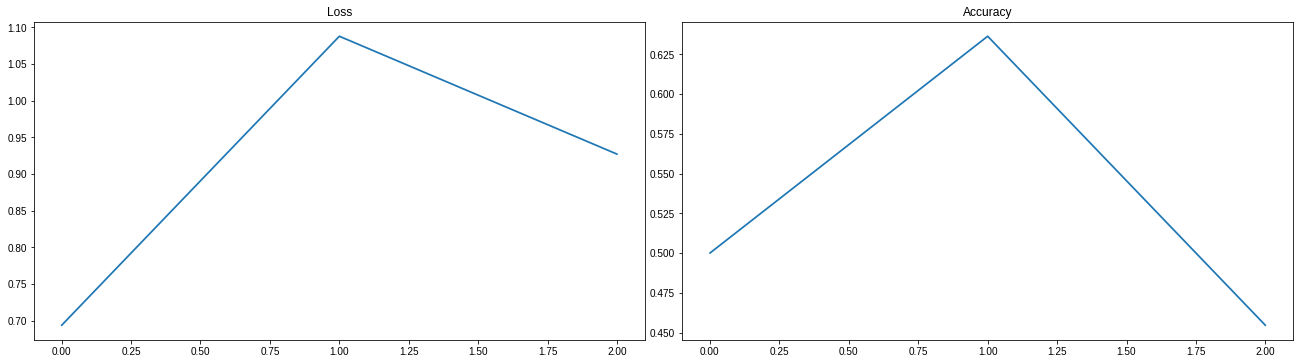

INFO:tensorflow:Assets written to: ./dev/models/20-02-17-10-29-11/assets


In [31]:
%%py_script -e -n mr_model.py -p demo/model/words/trainer -o ./dev/models --train_path gs://ai4ops/mldsl/data/demo_job_1576228028/train --words_path gs://ai4ops/mldsl/data/demo_job_1576228028/words --seq_len 100
#!/usr/bin/python

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import pandas as pd
    import numpy as np
    from tensorflow.python.lib.io import file_io
    from tensorflow.keras.utils import to_categorical
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense
    from tensorflow.keras.layers import LSTM, GRU
    from tensorflow.keras.layers import Embedding
    from tensorflow.keras.callbacks import Callback
    from tensorflow.keras.optimizers import Adam
    from tensorflow import keras
    import tensorflow as tf
    from tensorflow.core.protobuf import rewriter_config_pb2
    from tensorflow.keras.backend import set_session
    tf.keras.backend.clear_session()  # For easy reset of notebook state.

    import os
    from uuid import uuid4
    import argparse
    from datetime import datetime
    import matplotlib
    if matplotlib.get_backend() in ['TkAgg','TkCairo']:
        matplotlib.use('agg')
    import matplotlib.pyplot as plt
    import pickle
    import seaborn as sns

class MetricCallback(Callback):
        def on_train_begin(self,logs={}):
            self.losses = []
            self.accuracies = []

        def on_batch_end(self, batch, logs={}):
            self.losses.append(logs.get('loss'))
            self.accuracies.append(logs.get('acc'))
    
def read_csv(path):
    files = file_io.get_matching_files('{}/part*'.format(path))
    pdf = []
    for file in files:
        with file_io.FileIO(file, 'r') as f:
            df = pd.read_csv(f)
            if df is not None and len(df) != 0:
                pdf.append(df)
    if len(pdf) == 0:
        return None
    return pd.concat(pdf, axis=0, ignore_index=True).reset_index()

def shuffle(df, n=1, axis=0):
    df = df.copy()
    for _ in range(n):
        df.apply(np.random.shuffle, axis=axis)
    return df
    
def prepare_dataset(path, N):
    data = read_csv(path)
    data = shuffle(data)
    data['int_seq'] = data['int_seq'].apply(lambda x: [int(i) for i in x.split(',')])
    data['length'] = data['int_seq'].apply(lambda x: len(x))
    print("Max sequence is set to {}".format(N))
    data['int_seq'] = data['int_seq'].apply(lambda x: (x+[0]*N)[:N])
    ds_x = np.asarray(list(data["int_seq"]))
    ds_y = data["class"].values
    return ds_x, ds_y

def plot_metrics(callback, dir_to_save):
    f, axes = plt.subplots(1, 2,figsize=(18,5))
    plt.style.use('seaborn')
    plt.rcParams['axes.titlesize']=16
    sns.lineplot(x=range(len(callback.losses)), y = callback.losses, ax=axes[0])
    axes[0].title.set_text("Loss")
    sns.lineplot(x=range(len(callback.accuracies)), y = callback.accuracies, ax=axes[1])
    axes[1].title.set_text("Accuracy")
    plt.tight_layout(.5)
    plt.savefig('{}'.format(dir_to_save))
    plt.show()

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--train_path', type=str, help="Train files path")
    parser.add_argument('--words_path', type=str, help="Word files path")
    parser.add_argument('--output_path', type=str, help="Models output path")
    parser.add_argument('--seq_len', type=int, help="Length of input sequence")
    args, d = parser.parse_known_args()

    words = read_csv(args.words_path)
    words_dct = dict(zip(words['words_stemmed'].values, words['id'].values))
    with open("preprocessor.pkl",'wb') as f:
        pickle.dump(words_dct, f)
    
    N = args.seq_len
    train_x, train_y = prepare_dataset(args.train_path, N)

    vocabulary_size = max(words_dct.values())+1
    NUM_EPOCS = 3
    
    RNN_STATE_DIM = 128
    BATCH_SIZE = 64
    LEARNING_RATE = 0.05
    EMBED_SIZE = 128

    config_proto = tf.ConfigProto()
    off = rewriter_config_pb2.RewriterConfig.OFF
    config_proto.graph_options.rewrite_options.arithmetic_optimization = off
    session = tf.Session(config=config_proto)
    set_session(session)
    
    model = Sequential()
    model.add(Embedding(vocabulary_size, EMBED_SIZE, input_length=N))
    model.add(LSTM(RNN_STATE_DIM))
    model.add(Dense(1, activation='sigmoid'))
    
    print(model.summary())

    # compile model
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=LEARNING_RATE), metrics=['accuracy'])
    # fit model
    metrics = MetricCallback()
    a = model.fit(train_x, train_y, 
                  batch_size=BATCH_SIZE, epochs=NUM_EPOCS, callbacks=[metrics])

    # save the model to file
    local_dir = uuid4().hex
    #print('before create')
    file_io.recursive_create_dir(local_dir)
    #print('after create')
    #local_path = '{}/saved_model'.format(local_dir)
    #tf.saved_model.save(model, f'{local_dir}/saved_model')
    local_path_chart = '{}/metrics.png'.format(local_dir)
    plot_metrics(metrics, local_path_chart)
    
    remote_dir = args.output_path
    remote_path_chart = '{}/metrics.png'.format(remote_dir)
    if not remote_dir.startswith('gs://'):
        file_io.recursive_create_dir(remote_dir)
    tf.saved_model.save(model, '{}/'.format(remote_dir))
    file_io.copy(local_path_chart, remote_path_chart)
    file_io.delete_recursively(local_dir)

### Execute Trainer on ML Platform

running sdist
running egg_info
writing trainer.egg-info/PKG-INFO
writing dependency_links to trainer.egg-info/dependency_links.txt
writing requirements to trainer.egg-info/requires.txt
writing top-level names to trainer.egg-info/top_level.txt
reading manifest file 'trainer.egg-info/SOURCES.txt'
writing manifest file 'trainer.egg-info/SOURCES.txt'
running check
creating trainer-1.0
creating trainer-1.0/trainer
creating trainer-1.0/trainer.egg-info
creating trainer-1.0/trainer.egg-info/.ipynb_checkpoints
copying files to trainer-1.0...
copying README.md -> trainer-1.0
copying setup.py -> trainer-1.0
copying trainer/__init__.py -> trainer-1.0/trainer
copying trainer/model.py -> trainer-1.0/trainer
copying trainer/mr_model.py -> trainer-1.0/trainer
copying trainer.egg-info/PKG-INFO -> trainer-1.0/trainer.egg-info
copying trainer.egg-info/SOURCES.txt -> trainer-1.0/trainer.egg-info
copying trainer.egg-info/dependency_links.txt -> trainer-1.0/trainer.egg-info
copying trainer.egg-info/require

<IPython.core.display.JSON object>

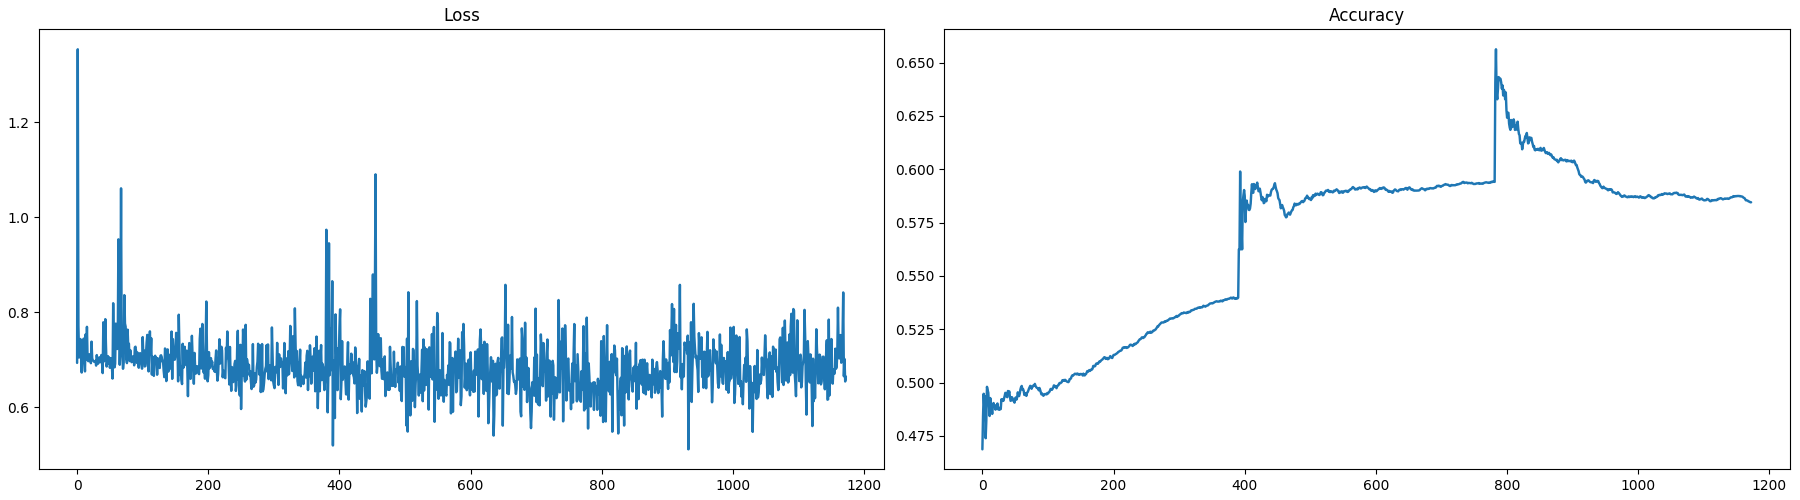

In [33]:
%py_train -n mr_model.py -s demo/model/words\
-p DemoAIProfile  -pm $platform\
-o gs://ai4ops/mldsl/models\
--train_path gs://ai4ops/mldsl/data/demo_job_1577030251/train\
--words_path gs://ai4ops/mldsl/data/demo_job_1577030251/words\
--seq_len 300

In [ ]:
#Use job_ai_train_demo_job_1581935492 instance to browse job properties.
job_ai_train_demo_job_1581935492 = job_tracker['ai_train_demo_job_1581935492']

## Deployment of model

##### Parameters of deployment: name of model, version, artifacts (models saved as .joblib, .h5 etc), custom code

In [9]:
model_name = "demo_mldsl"
version = "v3"
pyversion = 3.5

In [6]:
%py_deploy -n $model_name -v $version -p DemoDeployAIProfile  -pm $platform --framework TENSORFLOW\
-m gs://ai4ops/mldsl/models/ai_train_demo_job_1577179931 --pythonVersion $pyversion

Saved model to gs://ai4ops/demo_mldsl


<IPython.core.display.JSON object>

In [ ]:
#Use job_ai_train_demo_job_1581950746 instance to browse job properties.
job_ai_train_demo_job_1581950746 = job_tracker['ai_train_demo_job_1581950746']

## Prediction

In [4]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    from tensorflow.python.lib.io import file_io
    import pandas as pd
    import numpy as np

def read_csv(path):
    files = file_io.get_matching_files('{}/part*'.format(path))
    pdf = []
    for file in files:
        with file_io.FileIO(file, 'r') as f:
            df = pd.read_csv(f)
            if df is not None and len(df) != 0:
                pdf.append(df)
    if len(pdf) == 0:
        return None
    return pd.concat(pdf, axis=0, ignore_index=True).reset_index()

def prepare_dataset(path, N):
    data = read_csv(path)
    data['int_seq'] = data['int_seq'].apply(lambda x: [int(i) for i in x.split(',')])
    data['length'] = data['int_seq'].apply(lambda x: len(x))
    data['int_seq'] = data['int_seq'].apply(lambda x: (x+[0]*N)[:N])
    ds_x = np.asarray(list(data["int_seq"]))
    ds_y = data["class"].values
    return ds_x, ds_y
df_x, df_y = prepare_dataset('gs://ai4ops/mldsl/data/demo_job_1577030251/test', 300)
ints = np.random.choice(len(df_y), 200)

test_x = df_x[ints]
test_y = df_y[ints]
test = test_x.tolist()

In [10]:
%py_test -n $model_name -v v3 -p DemoDeployAIProfile -t $test -pm $platform

In [11]:
dense=[[0.25488606095314026], [0.30838608741760254], [0.4072822630405426], [0.3786965608596802], [0.15525144338607788], [0.23305156826972961], [0.1354656219482422], [0.8372814059257507], [0.08892762660980225], [0.3713282346725464], [0.4618474245071411], [0.1562180519104004], [0.6718777418136597], [0.6553439497947693], [0.4112316071987152], [0.32206153869628906], [0.24275138974189758], [0.3534340262413025], [0.5567026138305664], [0.6602811813354492], [0.22197675704956055], [0.07632425427436829], [0.7118769288063049], [0.38213205337524414], [0.29841309785842896], [0.38402917981147766], [0.6389526724815369], [0.20754292607307434], [0.19473817944526672], [0.37544408440589905], [0.3288467526435852], [0.07225751876831055], [0.5927079916000366], [0.37306511402130127], [0.32988691329956055], [0.8477085828781128], [0.3837416172027588], [0.3032299876213074], [0.3175886273384094], [0.30492302775382996], [0.4047829508781433], [0.4077865779399872], [0.6574926376342773], [0.5992149114608765], [0.07762303948402405], [0.24520343542099], [0.3974694609642029], [0.4586597681045532], [0.42748594284057617], [0.3382059335708618], [0.5831201672554016], [0.3341509699821472], [0.5373885631561279], [0.5296568870544434], [0.3803214430809021], [0.17759251594543457], [0.5758300423622131], [0.09795764088630676], [0.1366739571094513], [0.32804930210113525], [0.42247724533081055], [0.06559553742408752], [0.3898541033267975], [0.16480013728141785], [0.5066031217575073], [0.18178939819335938], [0.4342527389526367], [0.4421592950820923], [0.22545352578163147], [0.25880640745162964], [0.4921869933605194], [0.32224905490875244], [0.40361523628234863], [0.3308354318141937], [0.19015294313430786], [0.3557688593864441], [0.522013783454895], [0.6362909078598022], [0.5390780568122864], [0.1847013235092163], [0.5408143997192383], [0.18629279732704163], [0.49914661049842834], [0.4547087550163269], [0.5551296472549438], [0.2493116557598114], [0.31632357835769653], [0.22971338033676147], [0.2589361071586609], [0.04024764895439148], [0.08502885699272156], [0.17460864782333374], [0.44522824883461], [0.5436111092567444], [0.4454435408115387], [0.3297947645187378], [0.3574298620223999], [0.2882361114025116], [0.43720442056655884], [0.2998356223106384], [0.6698362827301025], [0.2692256271839142], [0.22706753015518188], [0.3296648859977722], [0.2535862922668457], [0.8150531053543091], [0.3721585273742676], [0.049326539039611816], [0.8903816938400269], [0.5668163299560547], [0.5928220748901367], [0.2200206220149994], [0.6760979890823364], [0.417930006980896], [0.6763142347335815], [0.92786705493927], [0.38328817486763], [0.2746852934360504], [0.16685763001441956], [0.34736019372940063], [0.2659223675727844], [0.4412340521812439], [0.3409103751182556], [0.40230974555015564], [0.46518832445144653], [0.35682377219200134], [0.303905189037323], [0.2069120705127716], [0.6384038925170898], [0.688270092010498], [0.4144497215747833], [0.6818468570709229], [0.5302560925483704], [0.04026448726654053], [0.45037585496902466], [0.46635347604751587], [0.17403936386108398], [0.32802605628967285], [0.4365878403186798], [0.45093834400177], [0.5589277744293213], [0.4943205416202545], [0.1645677387714386], [0.17063456773757935], [0.28224873542785645], [0.5643092393875122], [0.2007884681224823], [0.3940085172653198], [0.5674962997436523], [0.06646308302879333], [0.2557617425918579], [0.38150912523269653], [0.5108868479728699], [0.40015506744384766], [0.5954257249832153], [0.42641034722328186], [0.512881875038147], [0.4777953624725342], [0.44147789478302], [0.11353784799575806], [0.35202839970588684], [0.5407819747924805], [0.29310572147369385], [0.24119874835014343], [0.28569748997688293], [0.17937904596328735], [0.1810687780380249], [0.14852893352508545], [0.21196109056472778], [0.40207433700561523], [0.18704357743263245], [0.21406877040863037], [0.27467846870422363], [0.3172489404678345], [0.13118600845336914], [0.6209748983383179], [0.3213813006877899], [0.05565795302391052], [0.5572960376739502], [0.4635104238986969], [0.3941331207752228], [0.5414309501647949], [0.3108394742012024], [0.45487260818481445], [0.28505420684814453], [0.2028389871120453], [0.3136429786682129], [0.34315723180770874], [0.2743784189224243], [0.13925525546073914], [0.023509055376052856], [0.31902414560317993], [0.7046407461166382], [0.2449434995651245], [0.19448024034500122], [0.3157011568546295], [0.3264147639274597], [0.606838047504425], [0.6234597563743591], [0.13144999742507935]]

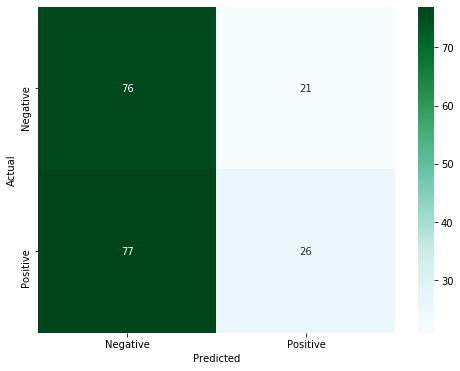

In [12]:
conf_mat = confusion_matrix(test_y, [round(i[0]) for i in dense])
fig, ax = plt.subplots(figsize=(8,6))
classes=['Negative', 'Positive']
sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=classes, yticklabels=classes, cmap=plt.cm.BuGn)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [13]:
classification_report(test_y, [round(i[0]) for i in dense],output_dict=True)

{'0': {'precision': 0.49673202614379086,
  'recall': 0.7835051546391752,
  'f1-score': 0.6080000000000001,
  'support': 97},
 '1': {'precision': 0.5531914893617021,
  'recall': 0.2524271844660194,
  'f1-score': 0.3466666666666667,
  'support': 103},
 'accuracy': 0.51,
 'macro avg': {'precision': 0.5249617577527466,
  'recall': 0.5179661695525973,
  'f1-score': 0.4773333333333334,
  'support': 200},
 'weighted avg': {'precision': 0.5258086497010152,
  'recall': 0.51,
  'f1-score': 0.4734133333333334,
  'support': 200}}